# Named-Entity Recognition
Implementation of a NER tagger following the paper _Neural Architectures for Named Entity Recognition_ from 2016 by Lample, Ballesteros, Subramanian, Kawakami, and Dyer.

Author: Pierre Nugues

## A note on the performance

Lample et .al reported a F1 performance of 89.15 without CRF and 90.94 with CRF. A paper by Nils Reimers and Iryna Gurevych (2017), _Reporting Score Distributions Makes a Difference: Performance Study of LSTM-networks for Sequence Tagging_, shows that the median performance is slightly lower topping at 90.81. Lample et .al used skip-n-grams; we use Glove here.

Guillaume Lample's implementation with Theano and Python 2 is available here: https://github.com/glample/tagger

## Imports

In [1]:
import regex as re
import numpy as np
import statistics
import random
import matplotlib.pyplot as plt
from sklearn import base
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Embedding, Dense, Dropout, TimeDistributed, concatenate
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.initializers import RandomUniform
# from tf2crf import CRF, ModelWithCRFLoss
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from tqdm import tqdm


EPOCHS = 100
CHAR_LSTM_UNITS = 25
LSTM_UNITS = 100
EMBEDDING_DIM = 100
CHAR_EMBEDDING_DIM = 25
RAND_INIT_RANGE = 0.05
PROB_SUBST = 0.5
BATCH_SIZE = 32
PATIENCE = 30
BINS = True
LOWER = True    # Tells if the words will be lowercased or not. 
                # This should match the embeddings case. We do not lowercase the character input

# Defaults
MAX_SENT_LEN_TRAIN = 150
MAX_SENT_LEN_DEV = 150
MAX_SENT_LEN_TEST = 150
MAX_WORD_LEN_TRAIN = 30
MAX_WORD_LEN_DEV = 30
MAX_WORD_LEN_TEST = 30

COLAB = False

## Collecting a Dataset

1. We use the CoNLL dataset on named entity recognition. There were two conferences on it: <a href="https://www.clips.uantwerpen.be/conll2002/ner/">CoNLL 2002</a> (Spanish and Dutch) and <a href="https://www.clips.uantwerpen.be/conll2003/ner/">CoNLL 2003</a> (English and German). We work here work on the English dataset.
3. The dataset comes in the form of three files: a training set, a development set, and a test set. <!--, named:
    <tt>eng.train</tt>, <tt>eng.testa</tt> (validation), and <tt>eng.testb</tt> (test).-->

In [2]:
if COLAB:
    from google.colab import drive
    drive.mount("/content/drive")
    EMBEDDING_DIR = '/content/drive/My Drive/Colab Notebooks/corpus/'
    EMBEDDING_FILE = 'glove.6B.100d.txt'
    BASE_DIR = '/content/drive/My Drive/Colab Notebooks/corpus/'
    RESULTS_DIR = '/content/drive/My Drive/Colab Notebooks/'
    MODELS_DIR = '/content/drive/My Drive/Colab Notebooks/'
else:
    EMBEDDING_DIR = '/Users/pierre/Documents/Cours/EDAN20/corpus/'
    EMBEDDING_FILE = 'glove.6B.100d.txt'
    BASE_DIR = '/Users/pierre/Projets/Corpora/CoNLL2003/'
    RESULTS_DIR = '/Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/results/'
    MODELS_DIR = '/Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/'

## Reading the Corpus

We read the corpus with the cells below. The functions will enable us to load the files in the form of a list of dictionaries.

In [3]:
def load_conll2003_en():
    train_file = BASE_DIR + 'NER-data/eng.train'
    dev_file = BASE_DIR + 'NER-data/eng.valid'
    test_file = BASE_DIR + 'NER-data/eng.test'
    column_names = ['form', 'ppos', 'pchunk', 'ner']
    train_sentences = open(train_file, encoding='utf8').read().strip()
    dev_sentences = open(dev_file, encoding='utf8').read().strip()
    test_sentences = open(test_file, encoding='utf8').read().strip()
    return train_sentences, dev_sentences, test_sentences, column_names

In [4]:
train_sentences, dev_sentences, test_sentences, column_names = load_conll2003_en()
train_sentences[:100]

'-DOCSTART- -X- O O\n\nEU NNP I-NP I-ORG\nrejects VBZ I-VP O\nGerman JJ I-NP I-MISC\ncall NN I-NP O\nto TO '

In [5]:
class Token(dict):
    pass


class CoNLLDictorizer(base.TransformerMixin):

    def __init__(self, column_names, sent_sep='\n\n', col_sep=' +'):
        self.column_names = column_names
        self.sent_sep = sent_sep
        self.col_sep = col_sep

    def fit(self):
        pass

    def transform(self, corpus):
        corpus = corpus.strip()
        sentences = re.split(self.sent_sep, corpus)
        return list(map(self._split_in_words, sentences))

    def fit_transform(self, corpus):
        return self.transform(corpus)

    def _split_in_words(self, sentence):
        rows = re.split('\n', sentence)
        return [Token(dict(zip(self.column_names,
                               re.split(self.col_sep, row))))
                for row in rows]

In [6]:
conll_dict = CoNLLDictorizer(column_names, col_sep=' +')
train_dict = conll_dict.transform(train_sentences)
dev_dict = conll_dict.transform(dev_sentences)
test_dict = conll_dict.transform(test_sentences)

In [7]:
print(train_dict[0])
print('\n'.join(map(str, train_dict[1])))

[{'form': '-DOCSTART-', 'ppos': '-X-', 'pchunk': 'O', 'ner': 'O'}]
{'form': 'EU', 'ppos': 'NNP', 'pchunk': 'I-NP', 'ner': 'I-ORG'}
{'form': 'rejects', 'ppos': 'VBZ', 'pchunk': 'I-VP', 'ner': 'O'}
{'form': 'German', 'ppos': 'JJ', 'pchunk': 'I-NP', 'ner': 'I-MISC'}
{'form': 'call', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'}
{'form': 'to', 'ppos': 'TO', 'pchunk': 'I-VP', 'ner': 'O'}
{'form': 'boycott', 'ppos': 'VB', 'pchunk': 'I-VP', 'ner': 'O'}
{'form': 'British', 'ppos': 'JJ', 'pchunk': 'I-NP', 'ner': 'I-MISC'}
{'form': 'lamb', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'}
{'form': '.', 'ppos': '.', 'pchunk': 'O', 'ner': 'O'}


## Evaluating the Models

We will train the models with the training set and use the test set to evaluate them. For this, we will apply the `conlleval` script that will compute the harmonic mean of the precision and recall: F1. 

`conlleval` was written in Perl. Some people rewrote it in Python and we use the translation here. The line below installs it.

In [8]:
!pip install conlleval
import conlleval

## Collecting the Embeddings

We will represent the words with the GloVe embeddings:
1. We download the GloVe embeddings 6B from <a href="https://nlp.stanford.edu/projects/glove/">https://nlp.stanford.edu/projects/glove/</a> and keep the 100d vectors.
2. We apply a function that reads GloVe embeddings and store them in a dictionary, where the keys will be the words and the values, the embeddings.

In [9]:
def read_embeddings(file):
    """
    Return the embeddings in the from of a dictionary
    :param file:
    :return:
    """
    embeddings = {}
    glove = open(file, encoding='utf8')
    for line in glove:
        values = line.strip().split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        embeddings[word] = vector
    glove.close()
    return embeddings

In [10]:
# We read the embeddings
embedding_file = EMBEDDING_DIR + EMBEDDING_FILE
embeddings_dict = read_embeddings(embedding_file)
embedded_words = sorted(list(embeddings_dict.keys()))
print('# words in embedding dictionary:', len(embedded_words))

# words in embedding dictionary: 400000


In [11]:
max([len(embeddings_dict[word]) for word in embeddings_dict.keys()])

100

## Extracting the $\mathbf{X}$ and $\mathbf{Y}$ Lists of Symbols

We use a `build_sequences(corpus_dict, key_x='form', key_y='ner', tolower=True)` function that for each sentence returns the $\mathbf{x}$ and $\mathbf{y}$ lists of symbols consisting of words and NER tags.

In [12]:
def build_sequences(corpus_dict, key_x='form', key_y='pos', tolower=True):
    """
    Creates sequences from a list of dictionaries
    :param corpus_dict:
    :param key_x:
    :param key_y:
    :return:
    """
    X = []
    Y = []
    for sentence in corpus_dict:
        x = [word[key_x] for word in sentence]
        y = [word[key_y] for word in sentence]
        if tolower:
            x = list(map(str.lower, x))
        X += [x]
        Y += [y]
    return X, Y

In [13]:
X_train_word_cat, Y_train_cat = build_sequences(train_dict, key_x='form', key_y='ner', tolower=False)
X_dev_word_cat, Y_dev_cat = build_sequences(dev_dict, key_x='form', key_y='ner', tolower=False)
X_test_word_cat, Y_test_cat = build_sequences(test_dict, key_x='form', key_y='ner', tolower=False)

In [14]:
print('First sentence, word input', X_train_word_cat[1])
print('First sentence, NER output', Y_train_cat[1])

First sentence, word input ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
First sentence, NER output ['I-ORG', 'O', 'I-MISC', 'O', 'O', 'O', 'I-MISC', 'O', 'O']


## Extracting the $\mathbf{X}$ Symbols

### Vocabulary from CoNLL

In [15]:
# We collect the words in their original case from the three sets
vocabulary_words_train = tuple([word
                          for sentence in X_train_word_cat
                          for word in sentence])
vocabulary_words_dev = tuple([word
                        for sentence in X_dev_word_cat
                        for word in sentence])
vocabulary_words_test = tuple([word
                         for sentence in X_test_word_cat
                         for word in sentence])

In [16]:
# We extract the unique words in their original case
#vocabulary_words_conll = list(vocabulary_words_train)
vocabulary_words_conll = tuple(sorted(list(set(vocabulary_words_train))))
print('#words:', len(vocabulary_words_conll))

#words: 23624


### Singletons

Lample et al. use the singletons to train the embeddings of the unknown word symbol. We extract them here.

In [17]:
# We extract the singletons
if LOWER:
    counts = Counter(map(str.lower, list(vocabulary_words_train)))
else:
    counts= Counter(vocabulary_words_train)
singletons = [k for k, v in counts.items() if counts[k] == 1]
len(singletons)

10060

### Characters from CoNLL

In [18]:
# We collect all the unique characters in their original case
chars = set(''.join(vocabulary_words_conll))
chars = tuple(sorted(list(chars)))

In [19]:
NB_CHARS = len(chars)
print('#chars:', NB_CHARS)

#chars: 84


### Stats on the the word lengths

Maximal length of a word, mean, and reasonable upperbound of a word length. Not used in the rest of the program.

In [20]:
MAX_WORD_LEN = max([len(word) for word in vocabulary_words_conll])
print('Word maximal length', MAX_WORD_LEN)

Word maximal length 61


In [21]:
statistics.mean([len(word) for word in vocabulary_words_conll])

6.832839485269218

In [22]:
statistics.mean([len(word) for word in vocabulary_words_conll]) + 3 * statistics.stdev(
    [len(word) for word in vocabulary_words_conll])

15.080759869694724

### Vocabulary from CoNLL and the Embeddings

We create a vocabulary of all the words observed in the training set and the words in the pretrained embeddings. We merge the list of unique CoNLL words with the words in the embedding file and we sort them. We store the vocabulary in `vocabulary_words`.

We align the case the CoNLL words with the embeddings

In [23]:
if LOWER:
    vocabulary_words = set(map(str.lower, vocabulary_words_conll))
else:
    vocabulary_words = set(vocabulary_words_conll)
print('# unique (possibly lowercased) words in the CoNLL vocabulary:',
      len(vocabulary_words))

# unique (possibly lowercased) words in the CoNLL vocabulary: 21010


In [24]:
# Adding vocabulary of embedded words
vocabulary_words = tuple(sorted(list(set(embedded_words + list(vocabulary_words)))))

In [25]:
print('# words in the vocabulary: embeddings and CoNLL corpus:', len(vocabulary_words))

# words in the vocabulary: embeddings and CoNLL corpus: 402595


## Extracting the $\mathbf{Y}$ Symbols

In [26]:
ner = tuple(sorted(set([ner
                  for sentence in Y_train_cat
                  for ner in sentence])))
NB_CLASSES = len(ner)
print(NB_CLASSES, 'named entity tags:', ner)

8 named entity tags: ('B-LOC', 'B-MISC', 'B-ORG', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O')


## Characters, Words, and NER Indices

We create the indices `word2idx`, `ner2idx` and inverted indices `idx2word`, `idx2ner` for the words and the NER. We use index 0 for the padding symbol and 1 for unknown words.

In [27]:
# We create the indexes
# For the words and chars, we start at two to make provision for
# the padding symbol 0 in RNN and LSTMs and unknown words/chars, 1
# We do not need it for the outpout
idx2char = dict(enumerate(chars, start=2))
idx2word = dict(enumerate(vocabulary_words, start=2))
idx2ner = dict(enumerate(ner, start=0))
char2idx = {v: k for k, v in idx2char.items()}
word2idx = {v: k for k, v in idx2word.items()}
ner2idx = {v: k for k, v in idx2ner.items()}

In [28]:
print('char index:', list(char2idx.items())[:10])
print('word index:', list(word2idx.items())[:10])
print('NER index:', list(ner2idx.items()))

char index: [('!', 2), ('"', 3), ('$', 4), ('%', 5), ('&', 6), ("'", 7), ('(', 8), (')', 9), ('*', 10), ('+', 11)]
word index: [('!', 2), ('!!', 3), ('!!!', 4), ('!!!!', 5), ('!!!!!', 6), ('!?', 7), ('!?!', 8), ('"', 9), ('#', 10), ('##', 11)]
NER index: [('B-LOC', 0), ('B-MISC', 1), ('B-ORG', 2), ('I-LOC', 3), ('I-MISC', 4), ('I-ORG', 5), ('I-PER', 6), ('O', 7)]


## Creating the $\mathbf{X}$ and $\mathbf{Y}$ Sequences

We now create the input and output sequences with numerical indices. First, we convert the $\mathbf{X}$ and $\mathbf{Y}$ lists of symbols in lists of numbers using the indices we created

### The Chararacters

In [29]:
def to_char_index(X, idx, UKN_IDX=1):
    """
    Convert the word lists (or POS lists) to char indexes
    :param X: List of word (or POS) lists
    :param idx: char to number dictionary
    :return: A list of x, where x is a list of char lists
    """
    X_idx = []
    for xl in X:
        # We map the unknown symbols to one
        x_idx = [list(map(lambda x: idx.get(x, UKN_IDX), list(x))) for x in xl]
        X_idx += [x_idx]
    return X_idx

In [30]:
# We create the parallel sequences of indexes for the chars in their original case
X_train_char_idx = to_char_index(X_train_word_cat, char2idx)
X_dev_char_idx = to_char_index(X_dev_word_cat, char2idx)
X_test_char_idx = to_char_index(X_test_word_cat, char2idx)

In [31]:
X_train_word_cat[:2]

[['-DOCSTART-'],
 ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']]

In [32]:
X_train_char_idx[:2]

[[[13, 34, 45, 33, 49, 50, 31, 48, 50, 13]],
 [[35, 51],
  [77, 64, 69, 64, 62, 79, 78],
  [37, 64, 77, 72, 60, 73],
  [62, 60, 71, 71],
  [79, 74],
  [61, 74, 84, 62, 74, 79, 79],
  [32, 77, 68, 79, 68, 78, 67],
  [71, 60, 72, 61],
  [14]]]

### The Words

In [33]:
# We set the words in lower case.
if LOWER:
    X_train_word_cat = [[x.lower() for x in x_vect] for x_vect in X_train_word_cat]
    X_dev_word_cat = [[x.lower() for x in x_vect] for x_vect in X_dev_word_cat]
    X_test_word_cat = [[x.lower() for x in x_vect] for x_vect in X_test_word_cat]

In [34]:
X_train_word_cat[1]

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']

In [35]:
def to_index(X, idx, UKN_IDX=1):
    """
    Convert the word lists (or POS lists) to indexes
    :param X: List of word (or POS) lists
    :param idx: word to number dictionary
    :return:
    """
    X_idx = []
    for x in X:
        # We map the unknown symbols to one
        x_idx = list(map(lambda x: idx.get(x, UKN_IDX), x))
        X_idx += [x_idx]
    return X_idx

In [36]:
# We create the parallel sequences of indexes for the words
# Train
X_train_word_idx = to_index(X_train_word_cat, word2idx)
# Dev
X_dev_word_idx = to_index(X_dev_word_cat, word2idx)
# Test
X_test_word_idx = to_index(X_test_word_cat, word2idx)

In [37]:
print('Train. Word indices:', X_train_word_idx[:2])
print('Dev. Word indices:', X_dev_word_idx[:2])
print('Test. Word indices:', X_test_word_idx[:2])

Train. Word indices: [[935], [142143, 307143, 161836, 91321, 363368, 83766, 85852, 218260, 936]]
Dev. Word indices: [[935], [113351, 679, 221875, 354360, 275584, 63471, 364505, 49150, 192163, 381011, 936]]
Test. Word indices: [[935], [338644, 679, 197600, 162137, 229067, 390518, 517, 100680, 190291, 350949, 120818, 936]]


### The NER Tags

In [38]:
# Train
Y_train_idx = to_index(Y_train_cat, ner2idx)
# Dev
Y_dev_idx = to_index(Y_dev_cat, ner2idx)
# Test
Y_test_idx = to_index(Y_test_cat, ner2idx)

In [39]:
print('Train. NER indices:', Y_train_idx[:2])
print('Dev. NER indices:', Y_dev_idx[:2])
print('Test. NER indices:', Y_test_idx[:2])

Train. NER indices: [[7], [5, 7, 4, 7, 7, 7, 4, 7, 7]]
Dev. NER indices: [[7], [7, 7, 5, 7, 7, 7, 7, 7, 7, 7, 7]]
Test. NER indices: [[7], [7, 7, 3, 7, 7, 7, 7, 6, 7, 7, 7, 7]]


## Padding

### Characters

We first pad the characters of a word to have a a length of `MAX_WORD_LEN`. We compute it for each set.

In [40]:
MAX_WORD_LEN_TRAIN = max([len(word)  for sentence in X_train_char_idx for word in sentence])
MAX_WORD_LEN_DEV = max([len(word)  for sentence in X_dev_char_idx for word in sentence])
MAX_WORD_LEN_TEST = max([len(word)  for sentence in X_test_char_idx for word in sentence])

In [41]:
X_train_char_idx = list(map(lambda x: pad_sequences(x, maxlen=MAX_WORD_LEN_TRAIN, padding='post'),
                            X_train_char_idx))
X_dev_char_idx = list(map(lambda x: pad_sequences(x, maxlen=MAX_WORD_LEN_DEV, padding='post'),
                          X_dev_char_idx))
X_test_char_idx = list(map(lambda x: pad_sequences(x, maxlen=MAX_WORD_LEN_TEST, padding='post'),
                           X_test_char_idx))

In [42]:
X_train_char_idx[:2]

[array([[13, 34, 45, 33, 49, 50, 31, 48, 50, 13,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int32),
 array([[35, 51,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [77, 64, 69, 64, 62, 79, 78,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [37, 64, 77, 72, 60, 73,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 

We then pad the lists of lists of characters to have a length of `MAX_SENT_LEN_TRAIN`. We determine it for each set.

In [43]:
MAX_SENT_LEN_TRAIN = max(map(len, X_train_word_idx))
MAX_SENT_LEN_DEV = max(map(len, X_dev_word_idx))
MAX_SENT_LEN_TEST = max(map(len, X_test_word_idx))

In [44]:
#X_train_char_idx = pad_sequences(X_train_char_idx, maxlen=MAX_SENT_LEN_TRAIN, padding='post')
X_dev_char_idx = pad_sequences(X_dev_char_idx, maxlen=MAX_SENT_LEN_DEV, padding='post')
X_test_char_idx = pad_sequences(X_test_char_idx, maxlen=MAX_SENT_LEN_TEST, padding='post')

In [45]:
X_train_char_idx[:2]

[array([[13, 34, 45, 33, 49, 50, 31, 48, 50, 13,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int32),
 array([[35, 51,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [77, 64, 69, 64, 62, 79, 78,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [37, 64, 77, 72, 60, 73,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 

### Words

We pad the word lists. Here we only pad the dev and test set to be able to predict in one go.

In [46]:
#X_train_word_idx = pad_sequences(X_train_word_idx, maxlen=MAX_SENT_LEN_TRAIN, padding='post')
X_dev_word_idx = pad_sequences(X_dev_word_idx, maxlen=MAX_SENT_LEN_DEV, padding='post')
X_test_word_idx = pad_sequences(X_test_word_idx, maxlen=MAX_SENT_LEN_TEST, padding='post')

In [47]:
X_train_word_idx[:2]

[[935], [142143, 307143, 161836, 91321, 363368, 83766, 85852, 218260, 936]]

We pad the NER lists

In [48]:
#Y_train_idx = pad_sequences(Y_train_idx, maxlen=MAX_SENT_LEN_TRAIN, padding='post')
Y_dev_idx = pad_sequences(Y_dev_idx, maxlen=MAX_SENT_LEN_DEV, padding='post')
Y_test_idx = pad_sequences(Y_test_idx, maxlen=MAX_SENT_LEN_TEST, padding='post')

In [49]:
Y_train_idx[:2]

[[7], [5, 7, 4, 7, 7, 7, 4, 7, 7]]

## Padding the training set

Depending on the training procedure, we need to pad or not the training set:
1. If we use `fit`, we have to pad;
2. We can also create bins of same length and train with `train_on_batch`. This allows for a more flexible training loop.

In [50]:
if not BINS:
    X_train_char_idx = pad_sequences(X_train_char_idx, maxlen=MAX_SENT_LEN_TRAIN, padding='post')
    X_train_word_idx = pad_sequences(X_train_word_idx, maxlen=MAX_SENT_LEN_TRAIN, padding='post')
    Y_train_idx = pad_sequences(Y_train_idx, maxlen=MAX_SENT_LEN_TRAIN, padding='post')  
training_bins = [list(zip(X_train_word_idx, X_train_char_idx, Y_train_idx))]

## Creating bins of same length

We create bins of sentences of the same length. This avoids padding

In [51]:
if BINS:
    training_set_sorted = sorted(zip(X_train_word_idx, 
                           X_train_char_idx, 
                           Y_train_idx), 
                       key=lambda x: len(x[0]))

We now create the histogram of sentence lengths. `groupby` is like the `uniq -c` shell command. We obtain a list of pairs: (sentence length, count of sentences that have this length)

In [52]:
from itertools import groupby
if BINS:
    train_sent_len_list = list(map(lambda x: len(x[0]), training_set_sorted))
    train_length_hist = [(x[0], len(list(x[1]))) for x in groupby(train_sent_len_list)]
    train_length_hist[:10]

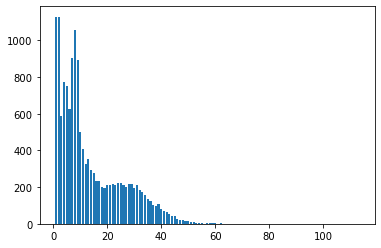

In [53]:
if BINS:
    plt.bar(list(map(lambda x: x[0], train_length_hist)),
        list(map(lambda x: x[1], train_length_hist)))

We create the bins

In [54]:
if BINS:
    training_bins = []
    for bin in train_length_hist:
        training_bins += [training_set_sorted[:bin[1]]]
        training_set_sorted = training_set_sorted[bin[1]:]

We print a few sentences of two words

In [55]:
if BINS:
    for i in range(5):
        print(training_bins[1][i])

([284434, 79019], array([[46, 64, 79, 64, 77,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [32, 71, 60, 62, 70, 61, 80, 77, 73,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int32), [6, 6])
([86920, 15423], array([[32, 48, 51, 49, 49, 35, 42, 49,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [17, 25, 25, 22, 13, 16, 24, 13, 18, 18,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,

## Embedding Matrix

Create a matrix of dimensions $(M, N)$, where $M$ will be the size of the vocabulary: The unique words in the training set and the words in GloVe, and $N$, the dimension of the embeddings.
The padding symbol and the unknown word symbol will be part of the vocabulary. The shape of your matrix should be: (402597, 100). Initialize it with random values.

In [56]:
np.random.seed(0)
# We add two dimensions for the padding symbol at index 0 and unknown words at index 1
embedding_matrix = np.random.uniform(-0.05, 0.05, (len(vocabulary_words) + 2, EMBEDDING_DIM))
# embedding_matrix = np.random.random((len(vocabulary_words) + 2, EMBEDDING_DIM))
# embedding_matrix = np.zeros((len(vocabulary_words) + 2, EMBEDDING_DIM))

In [57]:
print('Shape of embedding matrix:', embedding_matrix.shape)

Shape of embedding matrix: (402597, 100)


Fill the matrix with the GloVe embeddings when available. You will use the indices from the previous section. You will call `out_of_embeddings` the list of words in CoNLL, but not in the embedding list.

In [58]:
out_of_embeddings = []
for word in vocabulary_words:
    if word in embeddings_dict:
        # If the words are in the embeddings, we fill them with a value
        embedding_matrix[word2idx[word]] = embeddings_dict[word]
    else:
        # Otherwise, it keeps a random value in the matrix
        # We store the out of vocabulary words
        out_of_embeddings += [word]

In [59]:
print('Out of embeddings:', len(out_of_embeddings))
out_of_embeddings[-10:]

Out of embeddings: 2595


['zelezarny',
 'zhilan',
 'zieger',
 'zighayer',
 'zilinskiene',
 'zirka-nibas',
 'zuleeg',
 'zundra',
 'zwingmann',
 'zyrecha']

In [60]:
print('Embedding of the padding symbol, idx 0, random numbers', embedding_matrix[0][:10])
print('Embedding of table', embedding_matrix[word2idx['table']][:10])
if LOWER:
    print('Embedding of zwingmann, random numbers', embedding_matrix[word2idx['zwingmann']][:10])
else:
    print('Embedding of Zwingmann, random numbers', embedding_matrix[word2idx['Zwingmann']][:10])

Embedding of the padding symbol, idx 0, random numbers [ 0.00488135  0.02151894  0.01027634  0.00448832 -0.00763452  0.01458941
 -0.00624128  0.0391773   0.04636628 -0.01165585]
Embedding of table [-0.61453998  0.89692998  0.56770998  0.39102    -0.22437     0.49035001
  0.10868     0.27410999 -0.23833001 -0.52152997]
Embedding of zwingmann, random numbers [ 0.00782644 -0.02621394  0.04756559  0.00408949  0.01875676  0.01106755
  0.01659441  0.02207432 -0.03631456  0.00730187]


## A LSTM Network

In [61]:
#char input
# shape: (MAX_SENT_LEN, MAX_WORD_LEN,)
char_input = Input(shape=(None, None,))
embedded_chars = Embedding(input_dim=NB_CHARS + 2,
                                 output_dim=CHAR_EMBEDDING_DIM,
                                 trainable=True,
                                 mask_zero=True,
                                 embeddings_initializer=RandomUniform(minval=-RAND_INIT_RANGE,
                                                                      maxval=RAND_INIT_RANGE))(char_input)
encoded_chars = TimeDistributed(Bidirectional(LSTM(CHAR_LSTM_UNITS, return_sequences=False)))(embedded_chars)

In [62]:
# word input
# shape: (MAX_SENT_LEN,)
word_input = Input(shape=(None,))
embedded_words = Embedding(len(vocabulary_words) + 2,
                           EMBEDDING_DIM,
                           trainable=True,
                           mask_zero=True,
                           weights=[embedding_matrix])(word_input)

In [63]:
# concatenation
final_embeddings = concatenate([encoded_chars, embedded_words])

In [64]:
# dropout
final_embeddings = Dropout(0.5)(final_embeddings)

In [65]:
lstm_output = Bidirectional(LSTM(LSTM_UNITS,
                                 return_sequences=True))(final_embeddings)
"""lstm_output = Dropout(0.25)(lstm_output)
lstm_output = Bidirectional(LSTM(LSTM_UNITS,
                                 return_sequences=True))(lstm_output)"""
out = Dense(len(ner), activation='softmax')(lstm_output)

In [66]:
model = Model([char_input, word_input], out)

Compile it

In [67]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None)] 0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, None, 2 2150        input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, None, 50)     10200       embedding[0][0]                  
______________________________________________________________________________________________

## Function to save the results

The columns of an annotated corpus: We add `pner`

In [68]:
ann_column_names = ['form', 'ppos', 'pchunk', 'ner', 'pner']

In [69]:
def dict2conll(corpus_dict, column_names):
    """
    Saves the corpus in a file
    :param file:
    :param corpus_dict:
    :param column_names:
    :return:
    """
    corpus_str = ''
    for sentence in corpus_dict:
        sentence_lst = []
        for row in sentence:
            items = map(lambda x: row.get(x, '_'), column_names)
            sentence_lst += ' '.join(items) + '\n'
        sentence_lst += '\n'
        sentence_str = ''.join(sentence_lst)
        corpus_str += sentence_str
    return corpus_str

## Training the model

In [70]:
def minibatch_generator(dataset):
    # We take the sentences of the same length
    random.shuffle(dataset)
    for sentence_bin in dataset:
        random.shuffle(sentence_bin)
        # The number of batches. 
        batch_cnt = int(np.ceil((len(sentence_bin) / BATCH_SIZE)))
        # We create batches of BATCH_SIZE
        for j in range(batch_cnt):
            char_batch = []
            token_batch = []
            label_batch = []
            for sentence in sentence_bin[j*BATCH_SIZE:(j+1)*BATCH_SIZE]:
                tokens, chars, labels = sentence
                char_batch.append(chars)
                token_batch.append(tokens)
                label_batch.append(labels)
            #label_batch = list(map(lambda x: np.transpose([x]), label_batch))
            #label_batch = to_categorical(label_batch, num_classes=len(ner))
            yield  np.asarray(char_batch), np.asarray(token_batch), np.asarray(label_batch)

In [71]:
dev_scores = []
test_scores = []
for epoch in tqdm(range(EPOCHS)):
    print("Epoch {}/{}".format(epoch + 1, EPOCHS))
    for i, batch in enumerate(minibatch_generator(training_bins)):
        char_batch, token_batch, label_batch = batch
        # Symbol substitution to train the unknown word embedding
        new_token_batch = []
        for i, sentence in enumerate(token_batch):
            new_token_batch += [[1 if idx_word != 0 and counts[idx2word[idx_word]] == 1 and np.random.uniform() < PROB_SUBST
                                 else idx_word for idx_word in sentence]]
        new_token_batch = np.array(new_token_batch)
        loss = model.train_on_batch([char_batch, new_token_batch],
                                    label_batch)

    # We evaluate the dev set
    print('CoNLL score dev set')
    Y_dev_hat = model.predict([X_dev_char_idx, X_dev_word_idx])
    for sent, y_probs_hat in zip(dev_dict, Y_dev_hat):
        sent_len = len(sent)
        y_probs_hat = y_probs_hat[:sent_len]
        y_hat = map(np.argmax, y_probs_hat)
        for word, ner_hat in zip(sent, y_hat):
            word['pner'] = idx2ner[ner_hat]
    conll_str = dict2conll(dev_dict, ann_column_names)

    outfile = RESULTS_DIR + 'dev.out'
    with open(outfile, 'w', encoding='utf8') as f_out:
        f_out.write(conll_str)
    lines = open(outfile, encoding='utf8').read().splitlines()
    res = conlleval.evaluate(lines)
    dev_score = res['overall']['chunks']['evals']['f1']
    dev_scores += [dev_score] 
    print('dev', dev_score, flush=True)
       
    # We evaluate the test set
    print('CoNLL score test set')
    Y_test_hat = model.predict([X_test_char_idx, X_test_word_idx])
    for sent, y_probs_hat in zip(test_dict, Y_test_hat):
        sent_len = len(sent)
        y_probs_hat = y_probs_hat[:sent_len]
        y_hat = map(np.argmax, y_probs_hat)
        for word, ner_hat in zip(sent, y_hat):
            word['pner'] = idx2ner[ner_hat]
    conll_str = dict2conll(test_dict, ann_column_names)

    outfile = RESULTS_DIR + 'test.out'
    with open(outfile, 'w', encoding='utf8') as f_out:
        f_out.write(conll_str)
    lines = open(outfile, encoding='utf8').read().splitlines()
    res = conlleval.evaluate(lines)
    test_score = res['overall']['chunks']['evals']['f1']
    test_scores += [test_score]
    print('test', test_score, flush=True)
    
    if dev_score == max(dev_scores):
        model.save(MODELS_DIR)
    
    if max(dev_scores) > max(dev_scores[-PATIENCE - 1:]):
        break

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100
CoNLL score dev set
dev 0.7903757946407016
CoNLL score test set
test 0.7745295698924731


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets
  1%|          | 1/100 [02:41<4:26:55, 161.77s/it]

Epoch 2/100
CoNLL score dev set
dev 0.8513143710092047
CoNLL score test set
test 0.8295187538073275


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets
  2%|▏         | 2/100 [04:54<3:56:28, 144.78s/it]

Epoch 3/100
CoNLL score dev set
dev 0.8801732034307602
CoNLL score test set
test 0.852049287774185


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets
  3%|▎         | 3/100 [07:19<3:53:55, 144.70s/it]

Epoch 4/100
CoNLL score dev set
dev 0.8979523610530715
CoNLL score test set
test 0.8644393912891376


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets
  4%|▍         | 4/100 [09:39<3:48:30, 142.82s/it]

Epoch 5/100
CoNLL score dev set
dev 0.8975170804865856
CoNLL score test set
test 0.8586880669923238


  5%|▌         | 5/100 [11:39<3:33:06, 134.59s/it]

Epoch 6/100
CoNLL score dev set
dev 0.9078925412981813
CoNLL score test set
test 0.8749125262421273


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets
  6%|▌         | 6/100 [13:56<3:32:32, 135.67s/it]

Epoch 7/100
CoNLL score dev set
dev 0.9046822742474917
CoNLL score test set
test 0.8739260038576188


  7%|▋         | 7/100 [15:54<3:21:15, 129.84s/it]

Epoch 8/100
CoNLL score dev set
dev 0.9122338204592901
CoNLL score test set
test 0.8766477520733305


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets
  8%|▊         | 8/100 [18:16<3:24:39, 133.47s/it]

Epoch 9/100
CoNLL score dev set
dev 0.9199532085561497
CoNLL score test set
test 0.8730352776807545


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets
  9%|▉         | 9/100 [20:38<3:26:47, 136.34s/it]

Epoch 10/100
CoNLL score dev set
dev 0.9185444833917543
CoNLL score test set
test 0.8770827881008462


 10%|█         | 10/100 [22:36<3:15:42, 130.47s/it]

Epoch 11/100
CoNLL score dev set
dev 0.9234501798711621
CoNLL score test set
test 0.8797058308527403


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets
 11%|█         | 11/100 [24:56<3:18:02, 133.51s/it]

Epoch 12/100
CoNLL score dev set
dev 0.9219585561497327
CoNLL score test set
test 0.8774475524475525


 12%|█▏        | 12/100 [26:54<3:08:47, 128.72s/it]

Epoch 13/100
CoNLL score dev set
dev 0.9148687071416625
CoNLL score test set
test 0.8760185753088583


 13%|█▎        | 13/100 [28:56<3:03:46, 126.74s/it]

Epoch 14/100
CoNLL score dev set
dev 0.9243021208818845
CoNLL score test set
test 0.8816262157189171


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets
 14%|█▍        | 14/100 [31:17<3:07:48, 131.03s/it]

Epoch 15/100
CoNLL score dev set
dev 0.9253132832080202
CoNLL score test set
test 0.8795391061452514


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets
 15%|█▌        | 15/100 [33:38<3:10:05, 134.18s/it]

Epoch 16/100
CoNLL score dev set
dev 0.9216259076871713
CoNLL score test set
test 0.8767528960891908


 16%|█▌        | 16/100 [35:37<3:01:31, 129.66s/it]

Epoch 17/100
CoNLL score dev set
dev 0.9252031158388474
CoNLL score test set
test 0.8862779482683034


 17%|█▋        | 17/100 [37:37<2:55:03, 126.55s/it]

Epoch 18/100
CoNLL score dev set
dev 0.9246987951807228
CoNLL score test set
test 0.8818952705656089


 18%|█▊        | 18/100 [39:41<2:52:00, 125.86s/it]

Epoch 19/100
CoNLL score dev set
dev 0.9250754274220584
CoNLL score test set
test 0.8850705707022004


 19%|█▉        | 19/100 [41:51<2:51:39, 127.15s/it]

Epoch 20/100
CoNLL score dev set
dev 0.9248264905092399
CoNLL score test set
test 0.883724993448065


 20%|██        | 20/100 [43:50<2:46:09, 124.62s/it]

Epoch 21/100
CoNLL score dev set
dev 0.9261834939254294
CoNLL score test set
test 0.8809126810004388


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets
 21%|██        | 21/100 [46:14<2:51:46, 130.46s/it]

Epoch 22/100
CoNLL score dev set
dev 0.9273715002089428
CoNLL score test set
test 0.8835502751812702


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets
 22%|██▏       | 22/100 [48:35<2:53:32, 133.49s/it]

Epoch 23/100
CoNLL score dev set
dev 0.9244020739254056
CoNLL score test set
test 0.882404333391578


 23%|██▎       | 23/100 [50:33<2:45:24, 128.89s/it]

Epoch 24/100
CoNLL score dev set
dev 0.926343951174651
CoNLL score test set
test 0.8848039215686274


 24%|██▍       | 24/100 [52:29<2:38:16, 124.95s/it]

Epoch 25/100
CoNLL score dev set
dev 0.9298362846642164
CoNLL score test set
test 0.8832708569435969


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets
 25%|██▌       | 25/100 [55:00<2:46:07, 132.90s/it]

Epoch 26/100
CoNLL score dev set
dev 0.9267925789737589
CoNLL score test set
test 0.8853920797272488


 26%|██▌       | 26/100 [57:11<2:43:12, 132.33s/it]

Epoch 27/100
CoNLL score dev set
dev 0.9289471487016783
CoNLL score test set
test 0.8829127739456911


 27%|██▋       | 27/100 [59:20<2:39:50, 131.38s/it]

Epoch 28/100
CoNLL score dev set
dev 0.926841489894772
CoNLL score test set
test 0.8828418934289965


 28%|██▊       | 28/100 [1:01:17<2:32:31, 127.10s/it]

Epoch 29/100
CoNLL score dev set
dev 0.9226274935314247
CoNLL score test set
test 0.8783713241691318


 29%|██▉       | 29/100 [1:03:12<2:26:09, 123.51s/it]

Epoch 30/100
CoNLL score dev set
dev 0.925545249435949
CoNLL score test set
test 0.8822501747030048


 30%|███       | 30/100 [1:05:08<2:21:14, 121.06s/it]

Epoch 31/100
CoNLL score dev set
dev 0.9279264214046823
CoNLL score test set
test 0.8819875776397516


 31%|███       | 31/100 [1:07:03<2:17:13, 119.32s/it]

Epoch 32/100
CoNLL score dev set
dev 0.9274247491638796
CoNLL score test set
test 0.880650520241322


 32%|███▏      | 32/100 [1:08:57<2:13:34, 117.86s/it]

Epoch 33/100
CoNLL score dev set
dev 0.9306764902880107
CoNLL score test set
test 0.8841239278837738


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets


INFO:tensorflow:Assets written to: /Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/assets
 33%|███▎      | 33/100 [1:11:14<2:17:55, 123.51s/it]

Epoch 34/100
CoNLL score dev set
dev 0.9272742488911206
CoNLL score test set
test 0.8818484158935762


 34%|███▍      | 34/100 [1:13:07<2:12:14, 120.22s/it]

Epoch 35/100
CoNLL score dev set
dev 0.92779542035768
CoNLL score test set
test 0.8806282722513089


 35%|███▌      | 35/100 [1:14:59<2:07:42, 117.89s/it]

Epoch 36/100
CoNLL score dev set
dev 0.9272043460091934
CoNLL score test set
test 0.8819723727924462


 36%|███▌      | 36/100 [1:16:54<2:04:53, 117.09s/it]

Epoch 37/100
CoNLL score dev set
dev 0.9243473183751774
CoNLL score test set
test 0.8776275621456606


 37%|███▋      | 37/100 [1:18:50<2:02:27, 116.62s/it]

Epoch 38/100
CoNLL score dev set
dev 0.9267190898444037
CoNLL score test set
test 0.8824507658643326


 38%|███▊      | 38/100 [1:20:41<1:58:57, 115.13s/it]

Epoch 39/100
CoNLL score dev set
dev 0.9278247051936104
CoNLL score test set
test 0.8842215804673142


 39%|███▉      | 39/100 [1:22:34<1:56:20, 114.44s/it]

Epoch 40/100
CoNLL score dev set
dev 0.9275749728510567
CoNLL score test set
test 0.8781637283993716


 40%|████      | 40/100 [1:24:27<1:53:52, 113.87s/it]

Epoch 41/100
CoNLL score dev set
dev 0.927541093592754
CoNLL score test set
test 0.8856340992808279


 41%|████      | 41/100 [1:26:20<1:51:44, 113.64s/it]

Epoch 42/100
CoNLL score dev set
dev 0.9268211089738229
CoNLL score test set
test 0.884965034965035


 42%|████▏     | 42/100 [1:28:14<1:50:02, 113.83s/it]

Epoch 43/100
CoNLL score dev set
dev 0.9253406905777108
CoNLL score test set
test 0.8843834658743336


 43%|████▎     | 43/100 [1:30:09<1:48:16, 113.97s/it]

Epoch 44/100
CoNLL score dev set
dev 0.9243753655887023
CoNLL score test set
test 0.884679179397643


 44%|████▍     | 44/100 [1:32:03<1:46:26, 114.04s/it]

Epoch 45/100
CoNLL score dev set
dev 0.9229997491848507
CoNLL score test set
test 0.8889083122104712


 45%|████▌     | 45/100 [1:33:56<1:44:25, 113.92s/it]

Epoch 46/100
CoNLL score dev set
dev 0.9263562651508819
CoNLL score test set
test 0.8837372058437583


 46%|████▌     | 46/100 [1:35:50<1:42:32, 113.94s/it]

Epoch 47/100
CoNLL score dev set
dev 0.9289297658862876
CoNLL score test set
test 0.8858966512197255


 47%|████▋     | 47/100 [1:37:44<1:40:39, 113.95s/it]

Epoch 48/100
CoNLL score dev set
dev 0.9265678640207654
CoNLL score test set
test 0.8872364622517716


 48%|████▊     | 48/100 [1:39:38<1:38:38, 113.82s/it]

Epoch 49/100
CoNLL score dev set
dev 0.9238222519211495
CoNLL score test set
test 0.8863279203771608


 49%|████▉     | 49/100 [1:41:30<1:36:11, 113.17s/it]

Epoch 50/100
CoNLL score dev set
dev 0.9276987447698745
CoNLL score test set
test 0.8825485734290216


 50%|█████     | 50/100 [1:43:22<1:34:10, 113.01s/it]

Epoch 51/100
CoNLL score dev set
dev 0.9280575539568345
CoNLL score test set
test 0.8821932206358938


 51%|█████     | 51/100 [1:45:14<1:31:54, 112.55s/it]

Epoch 52/100
CoNLL score dev set
dev 0.9274200283972271
CoNLL score test set
test 0.8859236002093145


 52%|█████▏    | 52/100 [1:47:07<1:30:07, 112.67s/it]

Epoch 53/100
CoNLL score dev set
dev 0.9289115362125137
CoNLL score test set
test 0.8870021881838075


 53%|█████▎    | 53/100 [1:49:00<1:28:29, 112.96s/it]

Epoch 54/100
CoNLL score dev set
dev 0.925041736227045
CoNLL score test set
test 0.8815662966523905


 54%|█████▍    | 54/100 [1:50:53<1:26:32, 112.89s/it]

Epoch 55/100
CoNLL score dev set
dev 0.9232567849686848
CoNLL score test set
test 0.879230432881504


 55%|█████▌    | 55/100 [1:52:45<1:24:28, 112.63s/it]

Epoch 56/100
CoNLL score dev set
dev 0.9264105342111844
CoNLL score test set
test 0.8828043250784793


 56%|█████▌    | 56/100 [1:54:38<1:22:35, 112.63s/it]

Epoch 57/100
CoNLL score dev set
dev 0.9252710592160134
CoNLL score test set
test 0.885766646304215


 57%|█████▋    | 57/100 [1:56:31<1:20:56, 112.94s/it]

Epoch 58/100
CoNLL score dev set
dev 0.9274611398963731
CoNLL score test set
test 0.8810626583937778


 58%|█████▊    | 58/100 [1:58:24<1:18:55, 112.74s/it]

Epoch 59/100
CoNLL score dev set
dev 0.9289772727272728
CoNLL score test set
test 0.8834280717096632


 59%|█████▉    | 59/100 [2:00:17<1:17:08, 112.90s/it]

Epoch 60/100
CoNLL score dev set
dev 0.928828904350742
CoNLL score test set
test 0.882523504085757


 60%|██████    | 60/100 [2:02:09<1:15:13, 112.83s/it]

Epoch 61/100
CoNLL score dev set
dev 0.9270249937306696
CoNLL score test set
test 0.879153550192375


 61%|██████    | 61/100 [2:04:01<1:13:07, 112.49s/it]

Epoch 62/100
CoNLL score dev set
dev 0.9272011393147357
CoNLL score test set
test 0.8818014544817313


 62%|██████▏   | 62/100 [2:05:55<1:11:27, 112.82s/it]

Epoch 63/100
CoNLL score dev set
dev 0.9271844660194175
CoNLL score test set
test 0.8864893336844877


 63%|██████▎   | 63/100 [2:07:47<1:09:25, 112.58s/it]

Epoch 64/100
CoNLL score dev set
dev 0.9257496032740332
CoNLL score test set
test 0.8794338633583785


 63%|██████▎   | 63/100 [2:09:38<1:16:08, 123.47s/it]


In [72]:
np.argmax(dev_scores), max(dev_scores)

(32, 0.9306764902880107)

In [73]:
np.argmax(test_scores), max(test_scores)

(44, 0.8889083122104712)

In [74]:
"""callback_lists = [
    EarlyStopping(
        monitor='val_acc',
        patience=PATIENCE,
        restore_best_weights=True
    )
]"""

"callback_lists = [\n    EarlyStopping(\n        monitor='val_acc',\n        patience=PATIENCE,\n        restore_best_weights=True\n    )\n]"

In [75]:
"""history = model.fit([X_train_char_idx, X_train_word_idx], Y_train, epochs=EPOCHS, verbose=2,
                    validation_data=([X_dev_char_idx, X_dev_word_idx], Y_dev),
                    callbacks=callback_lists)"""

'history = model.fit([X_train_char_idx, X_train_word_idx], Y_train, epochs=EPOCHS, verbose=2,\n                    validation_data=([X_dev_char_idx, X_dev_word_idx], Y_dev),\n                    callbacks=callback_lists)'

We create a figure to show the training and validation losses and accuracies and a possible overfit.

In [76]:
"""acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracies')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation losses')
plt.legend()

plt.show()"""

"acc = history.history['acc']\nval_acc = history.history['val_acc']\nloss = history.history['loss']\nval_loss = history.history['val_loss']\n\nepochs = range(1, len(acc) + 1)\nplt.plot(epochs, acc, 'bo', label='Training accuracy')\nplt.plot(epochs, val_acc, 'b', label='Validation accuracy')\nplt.title('Training and validation accuracies')\nplt.legend()\n\nplt.figure()\nplt.plot(epochs, loss, 'bo', label='Training loss')\nplt.plot(epochs, val_loss, 'b', label='Validation loss')\nplt.title('Training and validation losses')\nplt.legend()\n\nplt.show()"

## Evaluating the System

We restore the best corpus

In [77]:
model = load_model(MODELS_DIR)

Predict the NER sequence

In [78]:
# We evaluate on all the test corpus
Y_test_hat = model.predict([X_test_char_idx, X_test_word_idx])

We predict one observation at a time to avoid padding. We could have a speed up with batches

In [79]:
"""Y_test_hat = []
for x_test_char_idx, x_test_word_idx in zip(X_test_char_idx, X_test_word_idx):
    y_pred_vect = model.predict([np.array([x_test_char_idx]), np.array([x_test_word_idx])])[0]
    Y_test_hat += [y_pred_vect]"""

'Y_test_hat = []\nfor x_test_char_idx, x_test_word_idx in zip(X_test_char_idx, X_test_word_idx):\n    y_pred_vect = model.predict([np.array([x_test_char_idx]), np.array([x_test_word_idx])])[0]\n    Y_test_hat += [y_pred_vect]'

Extract the indices of the highest probabilities from the lists and convert them into NER values. Add them with the `pner` key to the dictionaries in the `test_dict` list.

In [80]:
test_dict[1]

[{'form': 'SOCCER', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O', 'pner': 'O'},
 {'form': '-', 'ppos': ':', 'pchunk': 'O', 'ner': 'O', 'pner': 'O'},
 {'form': 'JAPAN',
  'ppos': 'NNP',
  'pchunk': 'I-NP',
  'ner': 'I-LOC',
  'pner': 'I-LOC'},
 {'form': 'GET', 'ppos': 'VB', 'pchunk': 'I-VP', 'ner': 'O', 'pner': 'O'},
 {'form': 'LUCKY', 'ppos': 'NNP', 'pchunk': 'I-NP', 'ner': 'O', 'pner': 'O'},
 {'form': 'WIN', 'ppos': 'NNP', 'pchunk': 'I-NP', 'ner': 'O', 'pner': 'O'},
 {'form': ',', 'ppos': ',', 'pchunk': 'O', 'ner': 'O', 'pner': 'O'},
 {'form': 'CHINA',
  'ppos': 'NNP',
  'pchunk': 'I-NP',
  'ner': 'I-PER',
  'pner': 'I-LOC'},
 {'form': 'IN', 'ppos': 'IN', 'pchunk': 'I-PP', 'ner': 'O', 'pner': 'O'},
 {'form': 'SURPRISE', 'ppos': 'DT', 'pchunk': 'I-NP', 'ner': 'O', 'pner': 'O'},
 {'form': 'DEFEAT', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O', 'pner': 'O'},
 {'form': '.', 'ppos': '.', 'pchunk': 'O', 'ner': 'O', 'pner': 'O'}]

In [81]:
Y_test_hat[1][:5]

array([[1.2137539e-14, 1.1481569e-12, 7.5563767e-15, 9.0416066e-08,
        1.1802445e-07, 2.2807811e-07, 2.2977916e-08, 9.9999952e-01],
       [8.5224227e-14, 1.0428600e-12, 1.9022128e-13, 1.5684378e-09,
        2.3755158e-09, 1.4266278e-09, 4.4725912e-09, 1.0000000e+00],
       [2.9626544e-12, 5.4487841e-11, 7.7545887e-14, 9.9999022e-01,
        9.3983914e-07, 2.6289644e-07, 8.4318463e-06, 8.0876426e-08],
       [5.0089954e-12, 8.5850864e-09, 7.9824531e-13, 3.0230112e-08,
        3.3426807e-07, 2.2746848e-07, 2.7122262e-05, 9.9997234e-01],
       [3.3692057e-14, 8.9679889e-11, 5.5928421e-15, 1.7148403e-07,
        1.3726685e-06, 3.8464139e-05, 1.4816503e-04, 9.9981183e-01]],
      dtype=float32)

In [82]:
for sent, y_probs_hat in zip(test_dict, Y_test_hat):
    sent_len = len(sent)
    y_probs_hat = y_probs_hat[:sent_len]
    y_hat = map(np.argmax, y_probs_hat)
    for word, ner_hat in zip(sent, y_hat):
        word['pner'] = idx2ner[ner_hat]

In [83]:
test_dict[1]

[{'form': 'SOCCER', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O', 'pner': 'O'},
 {'form': '-', 'ppos': ':', 'pchunk': 'O', 'ner': 'O', 'pner': 'O'},
 {'form': 'JAPAN',
  'ppos': 'NNP',
  'pchunk': 'I-NP',
  'ner': 'I-LOC',
  'pner': 'I-LOC'},
 {'form': 'GET', 'ppos': 'VB', 'pchunk': 'I-VP', 'ner': 'O', 'pner': 'O'},
 {'form': 'LUCKY', 'ppos': 'NNP', 'pchunk': 'I-NP', 'ner': 'O', 'pner': 'O'},
 {'form': 'WIN', 'ppos': 'NNP', 'pchunk': 'I-NP', 'ner': 'O', 'pner': 'O'},
 {'form': ',', 'ppos': ',', 'pchunk': 'O', 'ner': 'O', 'pner': 'O'},
 {'form': 'CHINA',
  'ppos': 'NNP',
  'pchunk': 'I-NP',
  'ner': 'I-PER',
  'pner': 'I-LOC'},
 {'form': 'IN', 'ppos': 'IN', 'pchunk': 'I-PP', 'ner': 'O', 'pner': 'O'},
 {'form': 'SURPRISE', 'ppos': 'DT', 'pchunk': 'I-NP', 'ner': 'O', 'pner': 'O'},
 {'form': 'DEFEAT', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O', 'pner': 'O'},
 {'form': '.', 'ppos': '.', 'pchunk': 'O', 'ner': 'O', 'pner': 'O'}]

## Saving the results

In [84]:
conll_str = dict2conll(test_dict, ann_column_names)

In [85]:
outfile = RESULTS_DIR + 'test.out'
with open(outfile, 'w', encoding='utf8') as f_out:
    f_out.write(conll_str)

In [86]:
lines = open(outfile, encoding='utf8').read().splitlines()
res = conlleval.evaluate(lines)
score = res['overall']['chunks']['evals']['f1']
score

0.8841239278837738

## Using the Recognizer to Tag a Sentence

A sentence

In [87]:
sentence = 'Yesterday , I met Pierre Nugues in Dammarie'

We create the character input

In [88]:
sent_char_idx = to_char_index([sentence.split()], char2idx)
MAX_WORD_LEN = max(map(len, sent_char_idx[0]))

In [89]:
sent_char_idx_padded = np.array(list(map(lambda x: pad_sequences(x, maxlen=MAX_WORD_LEN, padding='post'), 
                            sent_char_idx)))
sent_char_idx_padded

array([[[55, 64, 78, 79, 64, 77, 63, 60, 84],
        [12,  0,  0,  0,  0,  0,  0,  0,  0],
        [39,  0,  0,  0,  0,  0,  0,  0,  0],
        [72, 64, 79,  0,  0,  0,  0,  0,  0],
        [46, 68, 64, 77, 77, 64,  0,  0,  0],
        [44, 80, 66, 80, 64, 78,  0,  0,  0],
        [68, 73,  0,  0,  0,  0,  0,  0,  0],
        [34, 60, 72, 72, 60, 77, 68, 64,  0]]], dtype=int32)

And the word input

In [90]:
sent_word_idx = np.array(to_index([sentence.lower().split()], word2idx))
sent_word_idx

array([[396267,    517, 187251, 243996, 286609,      1, 190291,      1]])

And we predict the tags

In [91]:
y_probs_hat = model.predict([sent_char_idx_padded, sent_word_idx])

In [92]:
list(map(idx2ner.get, list(map(np.argmax, y_probs_hat[0]))[:len(sentence.split())]))

['O', 'O', 'O', 'O', 'I-PER', 'I-PER', 'O', 'I-LOC']

## Experiments

Results on the test set we reach a maximum on the dev set.

In [ ]:
# Average
# 0.8829712683952348 (54)
# 0.8821259428170496 (34)
# 0.8847668212442034 (84)
# 0.8806713873590348 (35)
# 0.8841239278837738 (32)

## Old Experiments

In [93]:
# Bins true
# 0.885002186270223
# 0.8899596986157351
# 0.8894348894348895
# 0.8900945047252363
# 0.8862642169728785
# 0.8840960897773102
# 0.8826010544815466 nadam, 108
# 0.8824767584634275 rmsprop (colab)
# 0.8877988963825874 rmsprop (colab), 33
# 0.886115992970123 rmsprop (colab), 73
# 0.8894732228942063 rmsprop (colab), 71
# 0.8851078758112613 rmsprop, 98
# 0.8805174372869503, batch 16, 27
# 0.8855564325177584, batch 32, 25

In [94]:
# Bins false
# 0.8886343612334803
# 0.8830532212885154

In [95]:
# Adding an extra LSTM
# 0.8962721424164978 (DO 50)
# 0.9005641748942173 (DO 25)
# 0.8945058802878708 (DO 0)
# 0.8960535588442565 (monodirectional, DO 25)
# 0.8924295774647887 (frist dropout of 0)

In [96]:
# 0.9005641748942173 (DO 25)
# 0.8998326138666197